# Re-analysis for "A novel cortical biomarker signature predicts individual pain sensitivity"

libaries

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, roc_auc_score
import subprocess
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

set your basepath

In [3]:
# Define base path
basepath = "/home/ole/projects/PAF_reanalysis"

## Main analysis

This does the following: \
\
(1) loads in complete dataset with PAF, CME and class for all subjects. \
(2) defines models and its parameter space \
(3) splits data in independent training and test set \
(4) uses gridsearch crossvalidation in training data to fit model \
(5) uses trained models to predict data of test set \
(6) reports accuracy and AUC for both, training and test set  \

This is repeatedly done to avoid an over/underestimation of the final metrics due to the relatively low sample size for a machine learning pipeline.

Number of repetitions is set by parameter repetitions.

set number of repetitions 

In [99]:
repetitions = 1000

Pipeline

In [100]:
# File paths for input data
paf_file = os.path.join(basepath, "data/PAF_all.xlsx")
cme_file = os.path.join(basepath, "data/map_volume_all.xlsx")
class_file = os.path.join(basepath, "data/class_IDs_all.xlsx")
yawn_pain_file = os.path.join(basepath, "data/yawn_pain_all.csv")
chew_pain_file = os.path.join(basepath, "data/chew_pain_all.csv")

# Load data from Excel and CSV files
df_paf = pd.read_excel(paf_file)
df_cme = pd.read_excel(cme_file)

# Calculate CME values: 1 for increase in volume, 0 otherwise
df_cme["CME"] = (df_cme["Volume_Day5"] - df_cme["Volume_Day0"]).apply(lambda x: 1 if x > 0 else 0)

# Load yawn and chew pain data, combining them
df_yawn_pain = pd.read_csv(yawn_pain_file)
df_chew_pain = pd.read_csv(chew_pain_file)
df_all_pain = df_chew_pain.add(df_yawn_pain, fill_value=0)
df_all_pain["ID"] = df_yawn_pain["ID"]

# get a mean for pain to stratify in random split
df_all_pain["pain_avg"] = df_all_pain.iloc[:, 1:14].mean(axis=1)
df_all_pain["pain_avg_binned"] = pd.qcut(df_all_pain["pain_avg"], q=4, labels=False)  # Quartiles

# Models and hyperparameters
models_and_params = {
    "LogisticRegression": (
        LogisticRegression(),
        {
            'model__C': np.logspace(-3, 3, 30),
            'model__solver':  ['newton-cg', 'lbfgs'],
            'model__max_iter': [200, 400, 2000, 5000]
        }
    )
    # commented out other models for now since LR outperforms + more complex models not suitable for data
    # ),
    # "RandomForest": (
    #     RandomForestClassifier(),
    #     {
    #         'model__n_estimators': [300, 500, 1000],
    #         'model__max_depth': [None, 5, 10],
    #         'model__min_samples_split': [2, 5, 10],
    #         'model__bootstrap': [True, False]
    #     }
    # ),
    # "GradientBoosting": (
    #     GradientBoostingClassifier(),
    #     {
    #         'model__learning_rate': [1, 0.1, 0.01, 0.01, 0.001],
    #         'model__max_depth': [None, 2, 5],
    #         'model__min_samples_split': [2, 5, 10],
    #         'model__n_estimators': [300, 500, 1000]
    #     }
    # ),
    # "SVC": (
    #     SVC(probability=True),
    #     {
    #         'model__C': [0.01, 0.1, 1, 10, 100],
    #         'model__gamma': ['scale', 'auto']
    #     }
    # ),
    # "MLPClassifier": (
    #     MLPClassifier(),
    #     {
    #         "model__alpha":[1e-3, 1e-2, 1e-1, 0, 1,10],
    #         "model__hidden_layer_sizes":[(100,),(100,100),(100,100,100)],
    #         "model__max_iter":[2000, 5000]
    #     }
    # )
}


# Initialize results list and random seeds
results = []
random_seeds = np.random.choice(np.arange(0, 10000), size=repetitions, replace=False)

# Loop through random seeds for cross-validation
for seed in random_seeds:
    print(f"Running analysis pipeline for seed = {seed}")
    # Split the combined pain data into training and testing sets
    X_train, X_test = train_test_split(
        df_all_pain, test_size=1/3, random_state=seed, stratify=df_all_pain["pain_avg_binned"]
    )

    # Save split data to CSV files for further processing
    X_train.to_csv(os.path.join(basepath, "data/X_train.csv"), index=False)
    X_test.to_csv(os.path.join(basepath, "data/X_test.csv"), index=False)

    # Execute R script for LGM model
    script_path = os.path.join(basepath, "run_LGM.R")
    subprocess.run(["Rscript", script_path], capture_output=True, text=True)

    # Load classification results from R script
    df_ID_LGM_train = pd.read_csv(os.path.join(basepath, "data/Y_train.csv"))
    df_ID_LGM_test = pd.read_csv(os.path.join(basepath, "data/Y_test.csv"))

    # Merge PAF and CME data with classification results for training and testing
    data_train = df_ID_LGM_train.merge(df_paf, on="ID", how="inner").merge(
        df_cme[["ID", "CME"]], on="ID", how="inner"
    )
    data_test = df_ID_LGM_test.merge(df_paf, on="ID", how="inner").merge(
        df_cme[["ID", "CME"]], on="ID", how="inner"
    )

    # Extract features (X) and target (Y) for model training and testing
    X_train, X_test = data_train[["sensorimotor_paf", "CME"]], data_test[["sensorimotor_paf", "CME"]]
    Y_train, Y_test = data_train["class"], data_test["class"]

    # Iterate over different models and their parameter grids
    for model_name, (model, param_grid) in models_and_params.items():
        # Create a machine learning pipeline
        pipeline = Pipeline([
            ("imputer", IterativeImputer(max_iter=100, random_state=seed)),
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        # Perform grid search cross-validation
        search = GridSearchCV(
            pipeline, param_grid=param_grid, cv=5,
            scoring="accuracy", verbose=0, n_jobs=-1
        )
        search.fit(X_train, Y_train)

        # Evaluate the best model on training and testing datasets
        best_model = search.best_estimator_
        for dataset, X_eval, y_eval, label in zip(
            ["train", "test"], [X_train, X_test], [Y_train, Y_test], ["Training", "Test"]
        ):
            y_pred = best_model.predict(X_eval)
            y_pred_proba = best_model.predict_proba(X_eval)[:, 1]
            accuracy = accuracy_score(y_eval, y_pred)
            auc = roc_auc_score(y_eval, y_pred_proba)
            results.append({
                "Seed": seed,
                "Model": model_name,
                "Dataset": label,
                "Accuracy": accuracy,
                "AUC": auc
            })

# Convert results to DataFrame for aggregation and saving
results_df = pd.DataFrame(results)

# Aggregate results by model and dataset
summary = results_df.groupby(["Model", "Dataset"]).mean()[["Accuracy", "AUC"]].reset_index()

# Save detailed and summary results to CSV files
results_path = os.path.join(basepath, "results")
os.makedirs(results_path, exist_ok=True)
results_df.to_csv(os.path.join(results_path, "results_all_runs.csv"), index=False)
summary.to_csv(os.path.join(results_path, "summary_results.csv"), index=False)

print("Analysis complete. Results saved.")


Running analysis pipeline for seed = 8671
Running analysis pipeline for seed = 4933
Running analysis pipeline for seed = 2645
Running analysis pipeline for seed = 1109
Running analysis pipeline for seed = 628
Running analysis pipeline for seed = 6663
Running analysis pipeline for seed = 3570
Running analysis pipeline for seed = 202
Running analysis pipeline for seed = 5954
Running analysis pipeline for seed = 8904
Running analysis pipeline for seed = 2499
Running analysis pipeline for seed = 3490
Running analysis pipeline for seed = 5583
Running analysis pipeline for seed = 4552
Running analysis pipeline for seed = 111
Running analysis pipeline for seed = 3057
Running analysis pipeline for seed = 8433
Running analysis pipeline for seed = 7610
Running analysis pipeline for seed = 4489
Running analysis pipeline for seed = 5931
Running analysis pipeline for seed = 8019
Running analysis pipeline for seed = 4967
Running analysis pipeline for seed = 3411
Running analysis pipeline for seed = 

## Create plots for accuracy and AUC for all models 
\
Plot will only display the average for both metrics across all repetitions of the pipeline

In [101]:
# Define the order of the Dataset categories
hue_order = ["Training", "Test"]

# Melt the DataFrame for easier plotting
plot_df = summary.melt(id_vars=["Model", "Dataset"], value_vars=["Accuracy", "AUC"], 
                       var_name="Metric", value_name="Score")

# Create the bar plot for Accuracy and AUC
for metric in ["Accuracy", "AUC"]:
    plt.figure(figsize=(12, 10))
    sns.barplot(
        data=plot_df[plot_df["Metric"] == metric],
        x="Score",
        y="Model",
        hue="Dataset",
        hue_order=hue_order,  # Ensure Training is always left and Test is right
        palette={"Training": "#9fc8c8", "Test": "#298c8c"}  # Adjust colors
    )

    # Add values on bars
    for container in plt.gca().containers:
        labels = [f"{v.get_width():.2f}" for v in container]
        plt.gca().bar_label(container, labels=labels, label_type='edge', fontsize=14)

    # Add title and labels
    plt.title(f"{metric} by Model", fontsize=20, fontweight="bold")
    plt.xlabel(metric, fontsize=16)
    plt.ylabel("Model", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title="Dataset", fontsize=14, title_fontsize=16, loc="lower right")

    # Remove grid lines
    plt.gca().grid(False)
    plt.gca().spines["left"].set_linewidth(0.5)
    plt.gca().spines["bottom"].set_linewidth(0.5)

    # Save the figure as an SVG
    filename = os.path.join(basepath, f"figures/{metric}_by_Model.svg")
    plt.tight_layout()
    plt.savefig(filename, format="svg")
    plt.close()  # Close the plot to avoid overlap

    print(f"Saved {metric} plot as SVG: {filename}")


Saved Accuracy plot as SVG: /home/ole/projects/PAF_reanalysis/figures/Accuracy_by_Model.svg
Saved AUC plot as SVG: /home/ole/projects/PAF_reanalysis/figures/AUC_by_Model.svg


## Create histogram of test set metrics (for different random seeds)

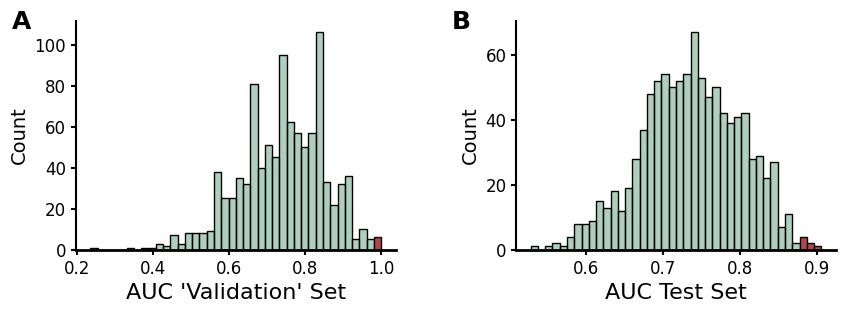

In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data for test set
file_path = os.path.join(basepath, "results/results_all_runs.csv")
results_df = pd.read_csv(file_path)

# Filter for LogisticRegression on Test dataset
logreg_test_df = results_df[(results_df["Model"] == "LogisticRegression") & (results_df["Dataset"] == "Test")]

# Load data for validation set
val_df = pd.read_csv(os.path.join(basepath, "results/val_set_AUC.csv"))

# Set up the figure with new size (set aspect ratio to be equal for both subplots)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

# Define colors
base_colors = ["#79AF9799", "#79AF9799"]
highlight_color = "#B2474BFF"

# Set font globally
plt.rcParams.update({"font.family": "DejaVu Sans", "font.size": 14})

# Function to create a histogram with a custom cut-off for highlighting
def plot_histogram(ax, data, xlabel, base_color, highlight_color, cutoff, label):
    # Compute histogram data
    counts, bins, patches = ax.hist(data, bins=40, color=base_color, edgecolor="black")

    # Ensure that the last bin also gets highlighted if it contains values above the cutoff
    for bar, left_edge, right_edge in zip(patches, bins[:-1], bins[1:]):  
        if right_edge > cutoff:  # Highlight bins where the **right edge** exceeds cutoff
            bar.set_facecolor(highlight_color)


    # Formatting
    ax.set_xlabel(xlabel, fontsize=16, fontweight="normal")
    ax.set_ylabel("Count", fontsize=14, fontweight="normal")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.5)  # Normal thickness
    ax.spines["bottom"].set_linewidth(2)  # Thicker x-axis
    ax.tick_params(axis="both", labelsize=12, width=1.5)
    
    # Add label ("A" or "B") in bold at the top-left, outside the plot area
    ax.text(-0.2, 1.05, label, transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

# Plot Validation Set AUC histogram (cut-off 0.99)
plot_histogram(axes[0], val_df["AUC"], "AUC 'Validation' Set", base_colors[0], highlight_color, 0.99, "A")

# Plot Test Set AUC histogram (cut-off 0.88)
plot_histogram(axes[1], logreg_test_df["AUC"], "AUC Test Set", base_colors[1], highlight_color, 0.88, "B")

# Adjust layout to prevent overlap and make it publication-ready
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.85, left=0.12, right=0.88)  # Adjust spacing for better presentation

# Save figure
plt.savefig(os.path.join(basepath, "figures/Metrics_testset_histogram_with_cutoff.svg"), format="svg", dpi=300)
plt.show()
